Introducing Forall
==================

Now turn our attention to the derivation steps allowed in **Prove-It**.  We will start with *specialization* and *generalization* which both relate to `Forall`, $\forall$.  As we examine *specialization*, it will be important to recall *expression substitution* in `tutorial01_core_expr`.  This is the most challenging and interesting derivation step.  The remaining derivation steps in subsequent tutorials are much more straightforward.

While `Forall` is a core concept, the **Forall** operation class is defined outside of the core.  It is defined in `proveit.logic.boolean.quantifiers.Forall` but is aliased as `proveit.Forall` (since it is a core concept and the core needs to access this class).  The core does not need to know the details of this `Forall` class.  For example, this class has various methods that are convenient for manipulating expressions with $\forall$, but the core only needs to know how to check that a given **Expression** is a `Forall` **Expression**, how to access its various kinds of sub-**Expression**s, and how to create a new `Forall` **Expression**

In [1]:
# Let us create a basic Forall expression and examine it
from proveit import Forall
from proveit.common import x, P, Px, Q, Qx, S
basicForallExpr = Forall(x, Px, conditions=[Qx], domain=S)
basicForallExpr

The meaning of this **Expression** is that $P(x)$ is a true statement for all instances of $x$ for which $x \in S$ and $Q(x)$ is true.  Let us examine the internal structure of this expression.

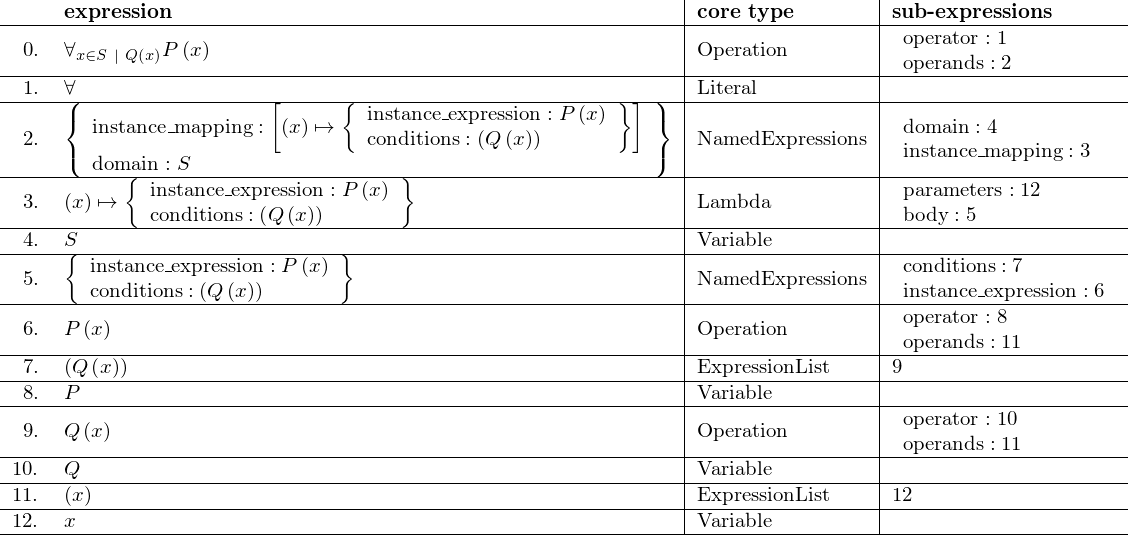

In [2]:
basicForallExpr.exprInfo()

`Forall` derives from `OperationOverInstances` (`proveit._generic_.operation_over_instances.OperationOverInstances` aliased as `proveit.OperationOverInstance`) which defines the **NamedExpression** structures with `domain`, `instance_mapping`, `conditions`, and `instance_expression` sub-**Expression** roles.  This is a useful structure for all of the `OperationOverInstances` type of expressions ($\exists$, $\sum$, $\prod$, etc., as well as $\forall$).  In our example above, the `instance_mapping` defines the $\forall$ quantification for each instance and is a **Lambda** that maps $x$ (the "instance variable") to an `instance_expression`, $P(x)$, as well as $x$-dependent `conditions`, $(Q(x))$.  The  `domain` over which $x$ is being quantified is $S$.  Each of these `Forall` parts may be accessed as follows:

In [3]:
basicForallExpr.instanceVars

In [4]:
basicForallExpr.instanceExpr

In [5]:
basicForallExpr.conditions

In [6]:
basicForallExpr.domain

Specialization
======


### Basic Specialization

Let us take our basic/generic example of the `Forall` expression above and specialize it with some other expression.  To do so, we will make assumptions to trivially allow this derivation step to be taken (just to show how this works).

In [7]:
from proveit import Operation, InSet
from proveit.common import fy
assumptions = {basicForallExpr, Operation(Q, fy), InSet(fy, S)}
stmt = basicForallExpr.specialize({x:fy}, assumptions=assumptions)
stmt

We have proven, somewhat trivially, that $P(f(y))$ is true assuming that $\forall_{x \in S | Q(x)} P(x)$, $f(y) \in S$, $Q(f(y))$ are all true statements.  Note that $f$ and $y$ are free **Variable**s in the $P(f(y))$ expression.  When we have a free variable in **Prove-It**, it is taken to represent some arbitrary **Variable** that can take on any value.  Indeed, as long as our assumptions hold, $f$ and $y$ could be anything (as long as $f$ represents some **Operation** that accepts one parameter, but this is straightforward to enforce in the context without explicitly indicating this restriction).  One may think of this statement as having an implicit, preceding $\forall_{f, y}$.  When we discuss *generalization* below, we will see how to make this explicit.

Let is take a look at the proof for this statement.

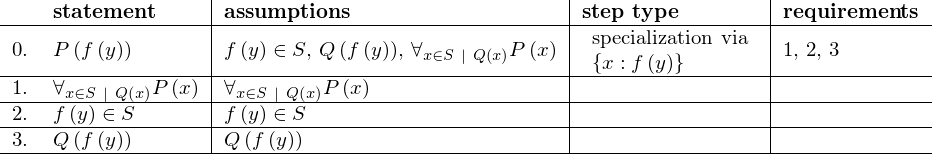

In [8]:
stmt.proof()

This indicates that the proof requires a *specialization* step and explicitly indicates the mapping being performed (taking $x$ to $f(y)$).  The subsequent proof steps that are required are simply proofs by assumption.

### Lambda scope restrictions

In `tutorial01_core_expr`, we noted scoping restrictions that apply to **Lambda** expressions in the context of *expression substitution*.  That restriction carries over to *specialization* and is very important.  Consider the following example.

In [9]:
from proveit.common import Pxy, y, fy
from proveit.logic import Exists, NotEquals
forallExistsExpr = Forall(x, Exists(y, NotEquals(x, y)))
forallExistsExpr

We are using `Exists` ($\exists$) and `Equals` ($\neq$) which do not have the special core status that `Forall` has and will be discussed further in the `logic` package tutorial.  We are just using them to make our point below more clear.  Just note that `Exists` has the same kind of structure as $\forall$ and specifically acts as on **Operation** on an **Expression** with a **Lambda** function.

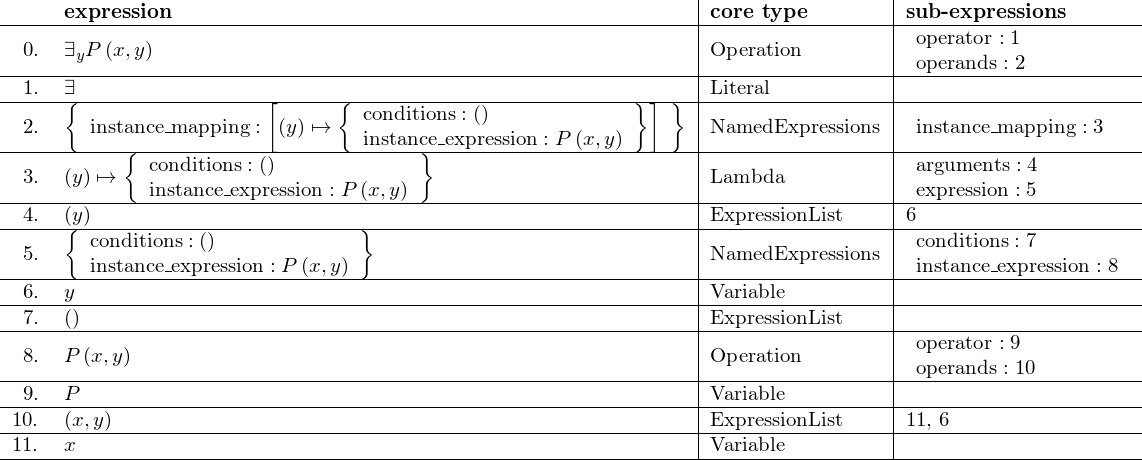

In [10]:
Exists(y, Pxy).exprInfo()

If we try to specialize $x$ as $y$ in `nestedForall`, this will fail:

In [12]:
from proveit import ScopingViolation
try:
    forallExistsExpr.specialize({x:y}, assumptions={forallExistsExpr})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Must not make substitution with reserved variables  (i.e., arguments of a Lambda function)


This should fail.  We cannot derive $\exists_y y \neq y$ by assuming $\forall_{ x } \left[\exists_y x \neq y \right]$.  The former is a stronger statement.  We chose this example, in fact, because the latter can be argued as typically true but the former is never true using reasonable definitions.  Where this goes wrong is in violating the scope of $\exists_y$.  It is introducing $y$ as new **Variable** within the sub-expression $\exists_y x \neq y$.  It is off limits to $x$ which is quantified outside of this sub-expression.  We can specialize $x$ to whatever we want as long as we respect these scoping restrictions.  It is not simply $y$ that is off limits; all expressions involving $y$ are off limits:

In [14]:
from proveit import ScopingViolation
try:
    forallExistsExpr.specialize({x:fy}, assumptions={forallExistsExpr})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Must not make substitution with reserved variables  (i.e., arguments of a Lambda function)


It should also be noted that within a scope, a **Variable** be reused with a different meaning.  This should generally be avoided as it makes **Expression**s unclear, but the functionality should be well-defined in case it every happens.  If this happens, we treat it as a distinct **Variable** from anything outside of the scope (that just happens to have the same name).  It can be confusing and should be avoided, but it is well-defined.  For example,

In [15]:
from proveit.logic import And
redundantInstanceVarExpr = Forall(x, And(Px, Forall(x, Qx)))
redundantInstanceVarExpr

In [16]:
# specializing the outer x does not and should not change the inner x which is treated as a distinct Variable
redundantInstanceVarExpr.specialize({x:fy}, assumptions={redundantInstanceVarExpr})

### Operand, operator, or operation specialization

*Specializing* different parts of an **Operation** works essentially the same way as it does with *expression substition*.  *Specializing* the operation itself will be slightly different but will be similar.

We will use the `substitution` axiom of `proveit.logic.equality` for demonstrations in this section out of convenience.  Axioms and the `proveit.logic` package will be discussed in more detail later.  For now, we note that axioms (and theorems) are taken to be true statements without proof as you can see below.

In [1]:
from proveit.logic.equality.axioms import substitution
substitution

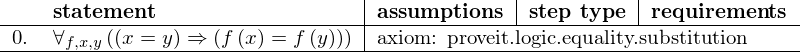

In [2]:
substitution.proof()

Operator and operand *specialization* is straightforward:

In [4]:
from proveit.common import f, g
gSubstitution = substitution.specialize({f:g})
gSubstitution._getOrMakeProver().stmtToProve

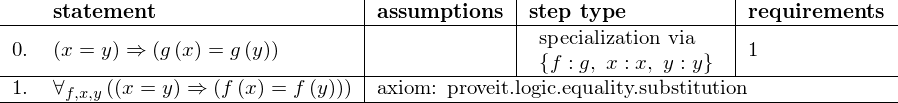

In [11]:
from proveit._core_.prover import Prover
Prover._tmpProvers[gSubstitution][0]

In [17]:
Forall((x, y), Pxy)

In [18]:
try:
    Forall((x, x), Px)
except ValueError as e:
    print 'EXPECTED ERROR:', e

EXPECTED ERROR: Lambda argument Variables must be unique with respect to each other.


### **ExpressionList**, 1-D **MultiVariable**s, and **Etcetera**

### **ExpressionTensor**, multi-dimensional **MultiVariable**s, and **Block**

Generalization
========